# Real-world Data Wrangling

In this project, you will apply the skills you acquired in the course to gather and wrangle real-world data with two datasets of your choice.

You will retrieve and extract the data, assess the data programmatically and visually, accross elements of data quality and structure, and implement a cleaning strategy for the data. You will then store the updated data into your selected database/data store, combine the data, and answer a research question with the datasets.

Throughout the process, you are expected to:

1. Explain your decisions towards methods used for gathering, assessing, cleaning, storing, and answering the research question
2. Write code comments so your code is more readable

Before you start, install the some of the required packages. 

In [1]:
!python -m pip install kaggle==1.6.12

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install --target=/workspace ucimlrepo

  Using cached ucimlrepo-0.0.7-py3-none-any.whl (8.0 kB)
  Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
  Using cached certifi-2024.6.2-py3-none-any.whl (164 kB)
  Using cached numpy-2.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.3 MB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.11.2 requires numpy<1.28.0,>=1.21.6, but you have numpy 2.0.0 which is incompatible.


In [3]:
!pip install openmeteo-requests

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install requests-cache retry-requests numpy pandas

Defaulting to user installation because normal site-packages is not writeable


**Note:** Restart the kernel to use updated package(s).

## 1. Gather data

In this section, you will extract data using two different data gathering methods and combine the data. Use at least two different types of data-gathering methods.

### **1.1.** Problem Statement
The primary goal of this project is to analyze the impact of weather conditions on taxi trip patterns in New York City. By examining both the NYC Taxi Trip dataset and weather data from the Open-Meteo API, we aim to identify how variables such as temperature, humidity, precipitation, and wind speed influence taxi demand, trip duration, and fare amounts. This analysis will provide insights into how weather conditions affect urban transportation and can help improve the efficiency and reliability of taxi services in the city.

Resources : 
* kaggle https://www.kaggle.com/datasets/anandaramg/taxi-trip-data-nyc/data?select=taxi_tripdata.csv
* open-meteo API https://open-meteo.com/en/docs/historical-weather-api#latitude=40.7128&longitude=74.006&start_date=2020-01-01&end_date=2021-12-31&hourly=temperature_2m,relative_humidity_2m,rain,snowfall,snow_depth,pressure_msl,wind_speed_100m,wind_direction_100m&daily=&temperature_unit=fahrenheit&timezone=America%2FNew_York


### **1.2.** I Gathered two datasets using two different data gathering methods

List of data gathering methods I used:

- Download data manually
- Gather data by accessing APIs


#### **Dataset 1: New York City Taxi Trip Data**
**Why this dataset was picked:**
The NYC Taxi Trip dataset provides a comprehensive record of taxi trips in New York City, including details such as pickup and dropoff locations, trip distance, fare amount, and various surcharges. This dataset is crucial for understanding urban mobility patterns and assessing how different factors, such as weather conditions, affect taxi usage.

Type: *CSV file*

Method: *Download data manually from : Dataset Source: https://www.kaggle.com/datasets/anandaramg/taxi-trip-data-nyc/data Taxi trip data NYC* 

Dataset variables:
- **VendorID**: A code indicating the provider associated with the trip record.
- **lpep_pickup_datetime**: The date and time when the trip started. This variable helps to analyze taxi demand patterns over different times of the day and seasons.
- **lpep_dropoff_datetime**: The date and time when the trip ended. This variable, along with the pickup datetime, can be used to calculate trip duration.
- **trip_distance**: The distance covered during the trip. This variable is essential for understanding the relationship between trip distance and fare amounts.
- **fare_amount**: The fare charged for the trip. This variable is crucial for analyzing the economic aspects of taxi operations.
- **total_amount**: The total amount charged for the trip, including all surcharges and taxes. This variable provides a complete picture of the cost of a taxi ride.
- **passenger_count**: The number of passengers in the taxi. This variable can be used to analyze trends in group travel and taxi sharing.
- **PULocationID** and **DOLocationID**: The pickup and dropoff location IDs. These variables help in mapping and spatial analysis of taxi trips across different areas of the city.


In [5]:
import requests
import pandas as pd
import os

taxi_df = pd.read_csv('taxi_tripdata.csv')


/tmp/ipykernel_217/2310846200.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  taxi_df = pd.read_csv('taxi_tripdata.csv')


#### Dataset 2 : Hourly weather forecast in NYC
**Why this dataset was picked:**
The weather data from the Open-Meteo API was chosen to complement the NYC Taxi Trip dataset. Weather conditions significantly affect transportation patterns, and analyzing this data can help in understanding how factors like temperature, precipitation, and wind speed influence taxi demand and travel times.



Type: *API Data.*

Method: *The data was gathered using the "weather_api" method from the Open-Meteo API.*

Dataset variables:

*   *Variable 1: temperature_2m* (e.g., 2-meter temperature in Degree Celsius)
*   *Variable 2: relative_humidity_2m* (e.g., Relative humidity at 2 meters)
*   *Variable 3: rain* (e.g., Rainfall)
*   *Variable 4: snowfall* (e.g., Snowfall)
*   *Variable 5: snow_depth* (e.g., Snow depth)
*   *Variable 6: pressure_msl* (e.g., Mean sea level pressure)
*   *Variable 7: wind_speed_100m* (e.g., Wind speed at 100 meters above ground level)
*   *Variable 8: wind_direction_100m* (e.g., Wind direction at 100 meters above ground level)


In [6]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 40.7128,
    "longitude": 74.006,
    "start_date": "2020-01-01",
    "end_date": "2021-12-31",
    "hourly": ["temperature_2m", "relative_humidity_2m", "rain", "snowfall", "snow_depth", "pressure_msl", "wind_speed_100m", "wind_direction_100m"],
    "temperature_unit": "fahrenheit",
    "timezone": "America/New_York"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_rain = hourly.Variables(2).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(3).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(4).ValuesAsNumpy()
hourly_pressure_msl = hourly.Variables(5).ValuesAsNumpy()
hourly_wind_speed_100m = hourly.Variables(6).ValuesAsNumpy()
hourly_wind_direction_100m = hourly.Variables(7).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["snow_depth"] = hourly_snow_depth
hourly_data["pressure_msl"] = hourly_pressure_msl
hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
hourly_data["wind_direction_100m"] = hourly_wind_direction_100m

hourly_dataframe = pd.DataFrame(data = hourly_data)




Coordinates 40.738136291503906°N 74.17021179199219°E
Elevation 3825.0 m asl
Timezone b'America/New_York' b'EDT'
Timezone difference to GMT+0 -14400 s


Optional data storing step: You may save your raw dataset files to the local data store before moving to the next step.

In [7]:
#Optional: store the raw data in your local data store

## 2. Assess data

Assess the data according to data quality and tidiness metrics using the report below.

List **two** data quality issues and **two** tidiness issues. Assess each data issue visually **and** programmatically, then briefly describe the issue you find.  **Make sure you include justifications for the methods you use for the assessment.**

### Quality Issue 1:  invalid entities for fare_count and total_count columns 

Dataset 1:

Visually assess

In [8]:
#FILL IN - Inspecting the dataframe visually
print("Shape of NYC Taxi Trip data:", taxi_df.shape)
taxi_df.head()

Shape of NYC Taxi Trip data: (83691, 20)


VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0       1.0  2021-07-01 00:30:52   2021-07-01 00:35:36                  N   
1       2.0  2021-07-01 00:25:36   2021-07-01 01:01:31                  N   
2       2.0  2021-07-01 00:05:58   2021-07-01 00:12:00                  N   
3       2.0  2021-07-01 00:41:40   2021-07-01 00:47:23                  N   
4       2.0  2021-07-01 00:51:32   2021-07-01 00:58:46                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         1.0            74           168              1.0           1.20   
1         1.0           116           265              2.0          13.69   
2         1.0            97            33              1.0           0.95   
3         1.0            74            42              1.0           1.24   
4         1.0            42           244              1.0           1.10   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  ehail_fee  \
0          6.0    0.5      0.5        0.00           0.0        NaN   
1         42.0    0.5      0.5        0.00           0.0        NaN   
2          6.5    0.5      0.5        2.34           0.0        NaN   
3          6.5    0.5      0.5        0.00           0.0        NaN   
4          7.0    0.5      0.5        0.00           0.0        NaN   

   improvement_surcharge  total_amount  payment_type  trip_type  \
0                    0.3          7.30           2.0        1.0   
1                    0.3         43.30           2.0        1.0   
2                    0.3         10.14           1.0        1.0   
3                    0.3          7.80           2.0        1.0   
4                    0.3          8.30           2.0        1.0   

   congestion_surcharge  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0

In [9]:
taxi_df.sample(10)

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
19667       2.0  2021-07-13 08:20:36   2021-07-13 08:53:31                  N   
59592       NaN  2021-07-19 19:32:00   2021-07-19 20:26:00                NaN   
9393        2.0  2021-07-06 19:06:07   2021-07-06 19:08:51                  N   
66329       NaN  2021-07-24 12:48:00   2021-07-24 13:29:00                NaN   
51383       NaN  2021-07-07 07:19:00   2021-07-07 08:02:00                NaN   
23226       1.0  2021-07-15 07:42:56   2021-07-15 07:54:01                  N   
73544       NaN  2021-07-29 06:29:00   2021-07-29 06:39:00                NaN   
53533       NaN  2021-07-16 21:50:00   2021-07-16 22:38:00                NaN   
11371       2.0  2021-07-07 20:53:59   2021-07-07 21:16:20                  N   
4658        2.0  2021-07-03 15:47:08   2021-07-03 15:57:30                  N   

       RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
19667         1.0           196           140              1.0           7.44   
59592         NaN           201           254              NaN          26.81   
9393          1.0            75            75              1.0           0.64   
66329         NaN           200           263              NaN          11.03   
51383         NaN           166           244              NaN           9.05   
23226         1.0            41           237              1.0           2.70   
73544         NaN            89            62              NaN           2.18   
53533         NaN           223            79              NaN           8.65   
11371         1.0           244           231              1.0           9.23   
4658          1.0            75            41              1.0           1.32   

       fare_amount  extra  mta_tax  tip_amount  tolls_amount  ehail_fee  \
19667        28.50   0.00      0.5        0.00           0.0        NaN   
59592        81.45   2.75      0.0        0.00           9.0        NaN   
9393          4.00   1.00      0.5        1.74           0.0        NaN   
66329        31.91   5.50      0.0        0.00           3.0        NaN   
51383        30.65   2.75      0.0        0.00           0.0        NaN   
23226        10.50   2.75      0.5        2.80           0.0        NaN   
73544        21.37   2.75      0.0        0.00           0.0        NaN   
53533        35.52   0.00      0.0        9.83           0.0        NaN   
11371        28.00   0.50      0.5        6.41           0.0        NaN   
4658          8.50   0.00      0.5        2.00           0.0        NaN   

       improvement_surcharge  total_amount  payment_type  trip_type  \
19667                    0.3         32.05           2.0        1.0   
59592                    0.3         93.50           NaN        NaN   
9393                     0.3          7.54           1.0        1.0   
66329                    0.3         40.71           NaN        NaN   
51383                    0.3         33.70           NaN        NaN   
23226                    0.3         16.85           1.0        1.0   
73544                    0.3         24.42           NaN        NaN   
53533                    0.3         48.40           NaN        NaN   
11371                    0.3         38.46           1.0        1.0   
4658                     0.3         11.30           1.0        1.0   

       congestion_surcharge  
19667                  2.75  
59592                   NaN  
9393                   0.00  
66329                   NaN  
51383                   NaN  
23226                  2.75  
73544                   NaN  
53533                   NaN  
11371                  2.75  
4658                   0.00

Programmatically assess:

In [10]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83691 entries, 0 to 83690
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               51173 non-null  float64
 1   lpep_pickup_datetime   83691 non-null  object 
 2   lpep_dropoff_datetime  83691 non-null  object 
 3   store_and_fwd_flag     51173 non-null  object 
 4   RatecodeID             51173 non-null  float64
 5   PULocationID           83691 non-null  int64  
 6   DOLocationID           83691 non-null  int64  
 7   passenger_count        51173 non-null  float64
 8   trip_distance          83691 non-null  float64
 9   fare_amount            83691 non-null  float64
 10  extra                  83691 non-null  float64
 11  mta_tax                83691 non-null  float64
 12  tip_amount             83691 non-null  float64
 13  tolls_amount           83691 non-null  float64
 14  ehail_fee              0 non-null      float64
 15  im

In [11]:
taxi_df.describe()

VendorID    RatecodeID  PULocationID  DOLocationID  \
count  51173.000000  51173.000000  83691.000000  83691.000000   
mean       1.851113      1.159244    108.362572    133.270005   
std        0.355981      0.773260     70.370170     77.216791   
min        1.000000      1.000000      3.000000      1.000000   
25%        2.000000      1.000000     56.000000     69.000000   
50%        2.000000      1.000000     75.000000    132.000000   
75%        2.000000      1.000000    166.000000    205.000000   
max        2.000000      5.000000    265.000000    265.000000   

       passenger_count  trip_distance   fare_amount         extra  \
count     51173.000000   83691.000000  83691.000000  83691.000000   
mean          1.307858     194.354699     20.388305      1.156707   
std           0.984362    4405.549221     15.583552      1.367897   
min           0.000000       0.000000   -150.000000     -4.500000   
25%           1.000000       1.350000      9.000000      0.000000   
50%           1.000000       2.760000     16.000000      0.500000   
75%           1.000000       6.200000     26.830000      2.750000   
max          32.000000  260517.930000    480.000000      8.250000   

            mta_tax    tip_amount  tolls_amount  ehail_fee  \
count  83691.000000  83691.000000  83691.000000        0.0   
mean       0.293562      1.058618      0.624529        NaN   
std        0.247773      2.368771      1.990481        NaN   
min       -0.500000     -1.140000      0.000000        NaN   
25%        0.000000      0.000000      0.000000        NaN   
50%        0.500000      0.000000      0.000000        NaN   
75%        0.500000      1.660000      0.000000        NaN   
max        0.500000     87.710000     30.050000        NaN   

       improvement_surcharge  total_amount  payment_type     trip_type  \
count           83691.000000  83691.000000  51173.000000  51173.000000   
mean                0.297745     24.204836      1.421726      1.034393   
std                 0.031219     17.262183      0.511146      0.182239   
min                -0.300000   -150.300000      1.000000      1.000000   
25%                 0.300000     11.760000      1.000000      1.000000   
50%                 0.300000     19.800000      1.000000      1.000000   
75%                 0.300000     31.300000      2.000000      1.000000   
max                 0.300000    480.310000      5.000000      2.000000   

       congestion_surcharge  
count          51173.000000  
mean               0.642815  
std                1.164219  
min               -2.750000  
25%                0.000000  
50%                0.000000  
75%                0.000000  
max                2.750000

In [12]:
taxi_df[taxi_df['fare_amount'] <= 0].count()

VendorID                 440
lpep_pickup_datetime     444
lpep_dropoff_datetime    444
store_and_fwd_flag       440
RatecodeID               440
PULocationID             444
DOLocationID             444
passenger_count          440
trip_distance            444
fare_amount              444
extra                    444
mta_tax                  444
tip_amount               444
tolls_amount             444
ehail_fee                  0
improvement_surcharge    444
total_amount             444
payment_type             440
trip_type                440
congestion_surcharge     440
dtype: int64

In [13]:
taxi_df[taxi_df['total_amount'] <= 0].count()

VendorID                 390
lpep_pickup_datetime     394
lpep_dropoff_datetime    394
store_and_fwd_flag       390
RatecodeID               390
PULocationID             394
DOLocationID             394
passenger_count          390
trip_distance            394
fare_amount              394
extra                    394
mta_tax                  394
tip_amount               394
tolls_amount             394
ehail_fee                  0
improvement_surcharge    394
total_amount             394
payment_type             390
trip_type                390
congestion_surcharge     390
dtype: int64




Issue: The fare_amount and total_amount columns might have negative or zero values which are not valid for fare amounts.


Visually assess using df.head() to spot-check for negative or zero values.                                            
Programmatically assess using df.describe() to find the minimum values and df[df['fare_amount'] <= 0] to count such instances.      
Justification: These methods ensure we identify and quantify the inaccuracies in fare-related columns.             

### Quality Issue 2:  Extreme Values in Weather Data


Dataset 2:

In [14]:
hourly_dataframe.head()

date  temperature_2m  relative_humidity_2m  rain  \
0 2020-01-01 04:00:00+00:00      -11.819202             72.383469   0.0   
1 2020-01-01 05:00:00+00:00       -7.229198             60.484665   0.0   
2 2020-01-01 06:00:00+00:00       -2.909203             52.399223   0.0   
3 2020-01-01 07:00:00+00:00        0.060801             46.170277   0.0   
4 2020-01-01 08:00:00+00:00        2.130802             40.043922   0.0   

   snowfall  snow_depth  pressure_msl  wind_speed_100m  wind_direction_100m  
0       0.0        0.78   1024.000000        12.313894           127.875046  
1       0.0        0.78   1023.200012        11.457958           133.727051  
2       0.0        0.78   1022.799988        11.200571           135.000107  
3       0.0        0.78   1021.500000         9.000000           143.130020  
4       0.0        0.78   1019.900024         8.557102           157.750931

In [15]:
hourly_dataframe.sample(10)

date  temperature_2m  relative_humidity_2m  rain  \
9570  2021-02-02 22:00:00+00:00      -11.009201             74.852310   0.0   
1515  2020-03-04 07:00:00+00:00       20.760799             51.411476   0.0   
6714  2020-10-06 22:00:00+00:00        9.330799             85.681633   0.0   
2861  2020-04-29 09:00:00+00:00       34.710800             62.690125   0.2   
12886 2021-06-21 02:00:00+00:00       32.730801             72.063507   0.0   
15152 2021-09-23 12:00:00+00:00       38.220798             39.676498   0.0   
13198 2021-07-04 02:00:00+00:00       39.300800             75.729462   0.0   
6750  2020-10-08 10:00:00+00:00       22.830799             77.935326   0.0   
10185 2021-02-28 13:00:00+00:00        0.600800             29.019823   0.0   
5206  2020-08-05 02:00:00+00:00       36.690800             82.083893   0.0   

       snowfall  snow_depth  pressure_msl  wind_speed_100m  \
9570       0.00        0.92   1031.400024        13.202726   
1515       0.00        0.90   1013.700012         8.209263   
6714       0.00        0.09   1027.099976         6.034700   
2861       0.00        0.49   1015.400024         5.447788   
12886      0.00        0.00   1019.299988         0.804985   
15152      0.00        0.00   1016.500000        10.594036   
13198      0.00        0.00   1014.700012         5.001280   
6750       0.21        0.15   1024.500000        10.685391   
10185      0.00        1.23   1022.700012         9.227524   
5206       0.00        0.00   1014.099976         7.421590   

       wind_direction_100m  
9570             78.996506  
1515            254.744827  
6714            162.645889  
2861            262.405457  
12886           153.435013  
15152           279.782349  
13198           149.743652  
6750            237.380768  
10185           159.443878  
5206             67.166313

In [16]:
hourly_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   date                  17544 non-null  datetime64[ns, UTC]
 1   temperature_2m        17544 non-null  float32            
 2   relative_humidity_2m  17544 non-null  float32            
 3   rain                  17544 non-null  float32            
 4   snowfall              17544 non-null  float32            
 5   snow_depth            17544 non-null  float32            
 6   pressure_msl          17544 non-null  float32            
 7   wind_speed_100m       17544 non-null  float32            
 8   wind_direction_100m   17544 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(8)
memory usage: 685.4 KB


In [17]:
hourly_dataframe.describe()

temperature_2m  relative_humidity_2m          rain      snowfall  \
count    17544.000000          17544.000000  17544.000000  17544.000000   
mean        17.612923             65.784538      0.032866      0.045410   
std         17.604399             21.286137      0.181937      0.174239   
min        -28.649200              8.053600      0.000000      0.000000   
25%          3.930801             49.682577      0.000000      0.000000   
50%         19.050800             67.517971      0.000000      0.000000   
75%         31.110800             83.753237      0.000000      0.000000   
max         61.980797            100.000000      7.000000      2.800000   

         snow_depth  pressure_msl  wind_speed_100m  wind_direction_100m  
count  17544.000000  17544.000000     17544.000000         17544.000000  
mean       0.506306   1020.901062         7.905742           186.489120  
std        0.464847      5.977007         3.836345            64.107635  
min        0.000000   1003.700012         0.000000             3.576264  
25%        0.000000   1016.700012         5.154416           142.124954  
50%        0.480000   1020.000000         7.235910           175.601379  
75%        0.830000   1024.500000        10.086427           237.744358  
max        1.690000   1045.199951        23.565567           360.000000




Issue: The weather data might contain invalid or extreme values that are not realistic for the location and period (e.g., extremely high temperatures or negative humidity values).                                              
Assessment:                                      
Visually assess using df_weather.head() to spot-check for unrealistic values.                             
Programmatically assess using df_weather.describe() to find the range and identify outliers.                             
Justification: These methods ensure we identify and quantify the invalid or extreme values in the dataset.                            
______________________________________________________________________________________________________________________________

### Tidiness Issue 1: Unnecessary Columns in Taxi Data (nulls , duplicated , dataTypes)


In [18]:
taxi_df.head()

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0       1.0  2021-07-01 00:30:52   2021-07-01 00:35:36                  N   
1       2.0  2021-07-01 00:25:36   2021-07-01 01:01:31                  N   
2       2.0  2021-07-01 00:05:58   2021-07-01 00:12:00                  N   
3       2.0  2021-07-01 00:41:40   2021-07-01 00:47:23                  N   
4       2.0  2021-07-01 00:51:32   2021-07-01 00:58:46                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         1.0            74           168              1.0           1.20   
1         1.0           116           265              2.0          13.69   
2         1.0            97            33              1.0           0.95   
3         1.0            74            42              1.0           1.24   
4         1.0            42           244              1.0           1.10   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  ehail_fee  \
0          6.0    0.5      0.5        0.00           0.0        NaN   
1         42.0    0.5      0.5        0.00           0.0        NaN   
2          6.5    0.5      0.5        2.34           0.0        NaN   
3          6.5    0.5      0.5        0.00           0.0        NaN   
4          7.0    0.5      0.5        0.00           0.0        NaN   

   improvement_surcharge  total_amount  payment_type  trip_type  \
0                    0.3          7.30           2.0        1.0   
1                    0.3         43.30           2.0        1.0   
2                    0.3         10.14           1.0        1.0   
3                    0.3          7.80           2.0        1.0   
4                    0.3          8.30           2.0        1.0   

   congestion_surcharge  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0

In [19]:
taxi_df.sample(5)

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
43843       2.0  2021-07-27 19:26:05   2021-07-27 19:35:35                  N   
71114       NaN  2021-07-30 16:11:00   2021-07-30 16:43:00                NaN   
51992       NaN  2021-07-16 18:01:00   2021-07-16 18:17:00                NaN   
33372       2.0  2021-07-21 12:25:13   2021-07-21 12:41:21                  N   
75699       NaN  2021-07-25 10:37:00   2021-07-25 11:06:00                NaN   

       RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
43843         1.0           223           223              1.0           1.53   
71114         NaN            95           218              NaN           6.02   
51992         NaN            61            65              NaN           3.02   
33372         1.0           166           244              1.0           4.12   
75699         NaN           193           173              NaN           5.15   

       fare_amount  extra  mta_tax  tip_amount  tolls_amount  ehail_fee  \
43843         8.00   1.00      0.5        0.00           0.0        NaN   
71114        34.35   1.35      0.0        0.00           0.0        NaN   
51992        14.17   0.00      0.0        3.22           0.0        NaN   
33372        15.00   0.00      0.5        3.00           0.0        NaN   
75699        21.45   2.75      0.0        0.00           0.0        NaN   

       improvement_surcharge  total_amount  payment_type  trip_type  \
43843                    0.3          9.80           2.0        1.0   
71114                    0.3         36.00           NaN        NaN   
51992                    0.3         17.69           NaN        NaN   
33372                    0.3         18.80           1.0        1.0   
75699                    0.3         24.50           NaN        NaN   

       congestion_surcharge  
43843                   0.0  
71114                   NaN  
51992                   NaN  
33372                   0.0  
75699                   NaN

In [20]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83691 entries, 0 to 83690
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               51173 non-null  float64
 1   lpep_pickup_datetime   83691 non-null  object 
 2   lpep_dropoff_datetime  83691 non-null  object 
 3   store_and_fwd_flag     51173 non-null  object 
 4   RatecodeID             51173 non-null  float64
 5   PULocationID           83691 non-null  int64  
 6   DOLocationID           83691 non-null  int64  
 7   passenger_count        51173 non-null  float64
 8   trip_distance          83691 non-null  float64
 9   fare_amount            83691 non-null  float64
 10  extra                  83691 non-null  float64
 11  mta_tax                83691 non-null  float64
 12  tip_amount             83691 non-null  float64
 13  tolls_amount           83691 non-null  float64
 14  ehail_fee              0 non-null      float64
 15  im

In [21]:
taxi_df.dtypes

VendorID                 float64
lpep_pickup_datetime      object
lpep_dropoff_datetime     object
store_and_fwd_flag        object
RatecodeID               float64
PULocationID               int64
DOLocationID               int64
passenger_count          float64
trip_distance            float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
ehail_fee                float64
improvement_surcharge    float64
total_amount             float64
payment_type             float64
trip_type                float64
congestion_surcharge     float64
dtype: object

In [22]:
taxi_df.isnull().sum()

VendorID                 32518
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag       32518
RatecodeID               32518
PULocationID                 0
DOLocationID                 0
passenger_count          32518
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
ehail_fee                83691
improvement_surcharge        0
total_amount                 0
payment_type             32518
trip_type                32518
congestion_surcharge     32518
dtype: int64

In [23]:
taxi_df.duplicated().sum()

np.int64(0)


There is no duplicated values 
___________________________________________________________________________________________________________________________


Issue 1: There are several columns with missing values and we don't want them to answer our question, such as VendorID, store_and_fwd_flag, payment_type, and trip_type.                                     
Assessment:                              
Visually assess using df.head() to see a snapshot of the data.                              
Programmatically assess using df.info() and df.isnull().sum() to quantify the missing values.                              
Justification: These methods provide a clear understanding of the extent of missing data and help identify which columns are most affected.                              




Issue 2: The date and time columns (lpep_pickup_datetime and lpep_dropoff_datetime) might have inconsistent formats.                              
Assessment:                              
Visually assess using taxi_df.sample() to see a snapshot of the datetime columns.                              
Programmatically assess using taxi_df.dtypes to check the data types of these columns.                              
Justification: These methods help verify that the datetime columns are in the correct format for further analysis.                              



### Tidiness Issue 2: 

In [24]:
hourly_dataframe.head()

date  temperature_2m  relative_humidity_2m  rain  \
0 2020-01-01 04:00:00+00:00      -11.819202             72.383469   0.0   
1 2020-01-01 05:00:00+00:00       -7.229198             60.484665   0.0   
2 2020-01-01 06:00:00+00:00       -2.909203             52.399223   0.0   
3 2020-01-01 07:00:00+00:00        0.060801             46.170277   0.0   
4 2020-01-01 08:00:00+00:00        2.130802             40.043922   0.0   

   snowfall  snow_depth  pressure_msl  wind_speed_100m  wind_direction_100m  
0       0.0        0.78   1024.000000        12.313894           127.875046  
1       0.0        0.78   1023.200012        11.457958           133.727051  
2       0.0        0.78   1022.799988        11.200571           135.000107  
3       0.0        0.78   1021.500000         9.000000           143.130020  
4       0.0        0.78   1019.900024         8.557102           157.750931

In [25]:
hourly_dataframe.sample(5)

date  temperature_2m  relative_humidity_2m  rain  \
9444  2021-01-28 16:00:00+00:00      -17.939201             50.988468   0.0   
637   2020-01-27 17:00:00+00:00       -3.629200             53.488781   0.0   
14622 2021-09-01 10:00:00+00:00       39.660801             53.374134   0.6   
639   2020-01-27 19:00:00+00:00       -8.399200             74.123726   0.0   
17412 2021-12-26 16:00:00+00:00       -6.869202             61.380474   0.0   

       snowfall  snow_depth  pressure_msl  wind_speed_100m  \
9444       0.00        0.98   1028.000000         8.049845   
637        0.07        0.83   1029.000000         6.924738   
14622      0.00        0.00   1020.000000        13.363711   
639        0.07        0.83   1029.500000         7.594207   
17412      0.00        0.78   1027.900024         3.671294   

       wind_direction_100m  
9444            116.564987  
637             188.972549  
14622           265.364624  
639             185.440247  
17412           191.309891

Programmatically assess:

In [26]:
hourly_dataframe.columns

Index(['date', 'temperature_2m', 'relative_humidity_2m', 'rain', 'snowfall',
       'snow_depth', 'pressure_msl', 'wind_speed_100m', 'wind_direction_100m'],
      dtype='object')

In [27]:
hourly_dataframe.shape

(17544, 9)

In [28]:
hourly_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   date                  17544 non-null  datetime64[ns, UTC]
 1   temperature_2m        17544 non-null  float32            
 2   relative_humidity_2m  17544 non-null  float32            
 3   rain                  17544 non-null  float32            
 4   snowfall              17544 non-null  float32            
 5   snow_depth            17544 non-null  float32            
 6   pressure_msl          17544 non-null  float32            
 7   wind_speed_100m       17544 non-null  float32            
 8   wind_direction_100m   17544 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(8)
memory usage: 685.4 KB


In [29]:
hourly_dataframe.isnull().sum()

date                    0
temperature_2m          0
relative_humidity_2m    0
rain                    0
snowfall                0
snow_depth              0
pressure_msl            0
wind_speed_100m         0
wind_direction_100m     0
dtype: int64

In [30]:
hourly_dataframe.duplicated().sum()

np.int64(0)

There is no null nor duplicated values in this dataset
_____________________________________________________________________________________________________

Thid dataset doesn't have clear tidiness issues

## 3. Clean data
Clean the data to solve the 4 issues corresponding to data quality and tidiness found in the assessing step. **Make sure you include justifications for your cleaning decisions.**

After the cleaning for each issue, please use **either** the visually or programatical method to validate the cleaning was succesful.

At this stage, you are also expected to remove variables that are unnecessary for your analysis and combine your datasets. Depending on your datasets, you may choose to perform variable combination and elimination before or after the cleaning stage. Your dataset must have **at least** 4 variables after combining the data.

In [31]:
taxi = taxi_df.copy()
weather = hourly_dataframe.copy()

### Quality Issue 1: invalid entities for fare_count and total_count columns ### 

In [32]:
invalid_fare_count = taxi[taxi['fare_amount'] <= 0].shape[0]
invalid_total_count = taxi[taxi['total_amount'] <= 0].shape[0]

print(f"Number of trips with invalid fare_amount: {invalid_fare_count}")
print(f"Number of trips with invalid total_amount: {invalid_total_count}")

Number of trips with invalid fare_amount: 444
Number of trips with invalid total_amount: 394


In [33]:
taxi = taxi[(taxi['fare_amount'] > 0) & (taxi['total_amount'] > 0)]

In [34]:
taxi[['fare_amount', 'total_amount']].describe()

fare_amount  total_amount
count  83247.00000  83247.000000
mean      20.50944     24.343475
std       15.52230     17.187644
min        0.01000      0.310000
25%        9.00000     11.800000
50%       16.00000     19.860000
75%       27.00000     31.310000
max      480.00000    480.310000

Justification:                  
- The `fare_amount` and `total_amount` columns should logically contain positive values only, as they represent monetary charges for taxi services.
- Negative or zero values in these columns indicate data inaccuracies or errors and could lead to incorrect analysis results.
- By removing rows with invalid values, we ensure that our dataset accurately reflects the financial aspects of taxi trips, which is crucial for reliable analysis of fare patterns and economic impact.

### Quality Issue 2:  Extreme Values in Weather Data


In [35]:
### Quality Issue 2:  Extreme Values in Weather Data
# Clean temperature_2m (Celsius)
weather = weather[(weather['temperature_2m'] >= -40) & (weather['temperature_2m'] <= 55)]

# Clean relative_humidity_2m
weather = weather[(weather['relative_humidity_2m'] >= 0) & (weather['relative_humidity_2m'] <= 100)]

# Clean rain, snowfall, and snow_depth
weather = weather[(weather['rain'] >= 0)]
weather = weather[(weather['snowfall'] >= 0)]
weather = weather[(weather['snow_depth'] >= 0)]

# Clean pressure_msl
weather = weather[(weather['pressure_msl'] >= 870) & (weather['pressure_msl'] <= 1080)]

# Clean wind_speed_100m
weather = weather[(weather['wind_speed_100m'] >= 0)]

# Clean wind_direction_100m
weather = weather[(weather['wind_direction_100m'] >= 0) & (weather['wind_direction_100m'] <= 360)]


In [36]:
# Validate the cleaning was successful
(weather.describe())

temperature_2m  relative_humidity_2m          rain      snowfall  \
count    17489.000000          17489.000000  17489.000000  17489.000000   
mean        17.487959             65.881660      0.032918      0.045553   
std         17.489885             21.243895      0.182202      0.174494   
min        -28.649200              8.053600      0.000000      0.000000   
25%          3.840799             49.841476      0.000000      0.000000   
50%         18.960800             67.641739      0.000000      0.000000   
75%         31.020800             83.798477      0.000000      0.000000   
max         54.870800            100.000000      7.000000      2.800000   

         snow_depth  pressure_msl  wind_speed_100m  wind_direction_100m  
count  17489.000000  17489.000000     17489.000000         17489.000000  
mean       0.507899   1020.929626         7.899360           186.170898  
std        0.464708      5.963303         3.837052            63.931034  
min        0.000000   1003.700012         0.000000             3.576264  
25%        0.000000   1016.799988         5.154416           142.124954  
50%        0.490000   1020.000000         7.208994           175.236450  
75%        0.830000   1024.500000        10.041354           237.264771  
max        1.690000   1045.199951        23.565567           360.000000

In [37]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17489 entries, 0 to 17543
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   date                  17489 non-null  datetime64[ns, UTC]
 1   temperature_2m        17489 non-null  float32            
 2   relative_humidity_2m  17489 non-null  float32            
 3   rain                  17489 non-null  float32            
 4   snowfall              17489 non-null  float32            
 5   snow_depth            17489 non-null  float32            
 6   pressure_msl          17489 non-null  float32            
 7   wind_speed_100m       17489 non-null  float32            
 8   wind_direction_100m   17489 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(8)
memory usage: 819.8 KB


Description: The weather data might contain invalid or extreme values that are not realistic for the location and period.

Justification:                               

Clean temperature_2m (Celsius)   :                                                           
Temperature values in Celsius are expected to be within a reasonable range based on historical weather data for most locations on Earth. Extremely low values (below -40°C) and extremely high values (above 55°C) are rare and often indicate data errors. By filtering out these outliers, we ensure the dataset contains realistic temperature values, improving the accuracy of any temperature-related analysis.                              


Clean relative_humidity_2m     :                         

Relative humidity is measured as a percentage and logically ranges from 0% (completely dry air) to 100% (air fully saturated with moisture). Values outside this range are physically impossible and indicate data errors. Cleaning this data ensures that all relative humidity values are valid, which is crucial for accurate climate and comfort-level analyses.                              


                                                            
Clean rain, snowfall, and snow_depth

Rain, snowfall, and snow depth should not have negative values, as these measurements represent quantities of precipitation and accumulated snow, which cannot be less than zero. By removing negative values, we ensure the integrity of the dataset, allowing for accurate precipitation analysis and forecasting.                              

Clean pressure_msl    :                                                                                      
Atmospheric pressure at mean sea level (msl) typically ranges between 870 hPa and 1080 hPa. Values outside this range are uncommon and usually indicate sensor errors or data entry mistakes. By filtering these outliers, we improve the reliability of pressure data, which is important for weather modeling and understanding atmospheric conditions.                                                            

Clean wind_speed_100m         :                                                   
Wind speed should not be negative, as it represents the magnitude of wind movement. Negative values are indicative of errors in measurement or data entry. Ensuring all wind speed values are non-negative maintains the dataset’s accuracy and is essential for analyses involving wind energy, weather prediction, and safety.

Clean wind_direction_100m                                                            
Wind direction is measured in degrees, ranging from 0 to 360, representing the direction from which the wind is blowing. Values outside this range are invalid and indicate data entry errors. Cleaning these values ensures the dataset's correctness, which is vital for accurately determining wind patterns and directions

### Tidiness Issue 1: Unnecessary Columns in Taxi Data (nulls , duplicated , dataTypes)


In [38]:
# FILL IN - Apply the cleaning strategy
columns_to_drop = ['VendorID', 'store_and_fwd_flag', 'payment_type', 'trip_type','ehail_fee']
taxi = taxi.drop(columns=columns_to_drop)

In [39]:
taxi.columns

Index(['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge'],
      dtype='object')

Justification: 

1. `VendorID`: This column is not necessary for the analysis as it only identifies the taxi vendor and does not provide useful information for the analysis of trip patterns or fare structures.
2. `store_and_fwd_flag`: This column indicates whether the trip record was held in vehicle memory before sending to the vendor. It is not useful for the analysis of trip data and does not impact trip patterns or fare amounts.
3. `payment_type`: This column describes the payment method, which is not relevant to the analysis of trip durations, distances, or fare amounts.
4. `trip_type`: This column differentiates between dispatched and non-dispatched trips, which is not relevant for the analysis of trip data.
5. `ehail_fee`: This column contains no data (all values are NaN) and thus is not useful for any analysis.




### Tidiness Issue 2 : convert dataType to datetime

In [40]:
taxi['date'] = pd.to_datetime(taxi['lpep_pickup_datetime'])
taxi['dropoff_date'] = pd.to_datetime(taxi['lpep_dropoff_datetime'])

columns_to_drop = ['lpep_dropoff_datetime','lpep_pickup_datetime']
taxi = taxi.drop(columns=columns_to_drop)

In [41]:
taxi.head()

RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         1.0            74           168              1.0           1.20   
1         1.0           116           265              2.0          13.69   
2         1.0            97            33              1.0           0.95   
3         1.0            74            42              1.0           1.24   
4         1.0            42           244              1.0           1.10   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0          6.0    0.5      0.5        0.00           0.0   
1         42.0    0.5      0.5        0.00           0.0   
2          6.5    0.5      0.5        2.34           0.0   
3          6.5    0.5      0.5        0.00           0.0   
4          7.0    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  \
0                    0.3          7.30                   0.0   
1                    0.3         43.30                   0.0   
2                    0.3         10.14                   0.0   
3                    0.3          7.80                   0.0   
4                    0.3          8.30                   0.0   

                 date        dropoff_date  
0 2021-07-01 00:30:52 2021-07-01 00:35:36  
1 2021-07-01 00:25:36 2021-07-01 01:01:31  
2 2021-07-01 00:05:58 2021-07-01 00:12:00  
3 2021-07-01 00:41:40 2021-07-01 00:47:23  
4 2021-07-01 00:51:32 2021-07-01 00:58:46

In [43]:
taxi['date'] = pd.to_datetime(taxi['date']).dt.tz_localize('UTC')

In [75]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83247 entries, 0 to 83690
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   RatecodeID             50733 non-null  float64            
 1   PULocationID           83247 non-null  int64              
 2   DOLocationID           83247 non-null  int64              
 3   passenger_count        50733 non-null  float64            
 4   trip_distance          83247 non-null  float64            
 5   fare_amount            83247 non-null  float64            
 6   extra                  83247 non-null  float64            
 7   mta_tax                83247 non-null  float64            
 8   tip_amount             83247 non-null  float64            
 9   tolls_amount           83247 non-null  float64            
 10  improvement_surcharge  83247 non-null  float64            
 11  total_amount           83247 non-null  float64            


Justification:                      
The pd.to_datetime() function is used to convert the 'lpep_pickup_datetime' and 'lpep_dropoff_datetime' columns from string format to datetime format. This conversion is necessary to facilitate date-based operations and analyses, such as calculating trip durations, grouping data by time periods, and extracting specific components like hour, day, or month. Storing these datetime objects in new columns (pickup_date and dropoff_date) preserves the original data while allowing for efficient date manipulations and queries.

### **Remove unnecessary variables and combine datasets**

Depending on the datasets, you can also peform the combination before the cleaning steps.

In [69]:
#FILL IN - Remove unnecessary variables and combine datasets
combined_data = pd.merge(taxi, weather, on='date', how='inner')


In [70]:
combined_data.head()

RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         1.0            75           236              1.0           1.20   
1         1.0            74           247              1.0           2.09   
2         1.0            95           121              2.0           2.53   
3         1.0            74           237              1.0           3.31   
4         1.0           213           197              1.0          15.92   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  ...  \
0          7.0   2.75      0.5        2.10          0.00  ...   
1          8.5   0.00      0.5        2.79          0.00  ...   
2         11.0   0.00      0.5        1.00          0.00  ...   
3         16.0   0.00      0.5        0.00          0.00  ...   
4         52.0   0.50      0.5        0.00          6.55  ...   

                       date        dropoff_date  temperature_2m  \
0 2021-07-02 15:00:00+00:00 2021-07-02 15:07:39       34.890800   
1 2021-07-03 12:00:00+00:00 2021-07-03 12:07:11       45.870800   
2 2021-07-06 08:00:00+00:00 2021-07-06 08:10:06       48.750801   
3 2021-07-08 13:00:00+00:00 2021-07-08 13:21:52       51.270802   
4 2021-07-13 06:00:00+00:00 2021-07-13 06:44:33       41.280800   

  relative_humidity_2m rain  snowfall  snow_depth  pressure_msl  \
0            93.065773  0.2       0.0         0.0   1015.700012   
1            57.156956  0.1       0.0         0.0   1012.299988   
2            55.337654  0.0       0.0         0.0   1013.700012   
3            50.208988  0.0       0.0         0.0   1017.400024   
4            59.273697  0.5       0.0         0.0   1013.099976   

   wind_speed_100m  wind_direction_100m  
0         6.830519            71.564964  
1         7.244860           296.564972  
2        11.525623           268.210114  
3         8.217153           298.810699  
4        10.495713           239.036301  

[5 rows x 23 columns]

## 4. Update your data store
Update your local database/data store with the cleaned data, following best practices for storing your cleaned data:

- Must maintain different instances / versions of data (raw and cleaned data)
- Must name the dataset files informatively
- Ensure both the raw and cleaned data is saved to your database/data store

In [46]:
#FILL IN - saving data
# Save raw data to files
taxi_df.to_csv('raw_taxi_data.csv', index=False)
hourly_dataframe.to_csv('raw_weather_data.csv', index=False)
# Save cleaned data to files
taxi.to_csv('cleaned_taxi_data.csv', index=False)
weather.to_csv('cleaned_weather_data.csv', index=False)

combined_data.to_csv('combined_data.csv', index=False)


## 5. Answer the research question

### **5.1:** Define and answer the research question 
Going back to the problem statement in step 1, use the cleaned data to answer the question you raised. Produce **at least** two visualizations using the cleaned data and explain how they help you answer the question.

Research question: How do weather conditions influence taxi trip patterns in New York City?

###  `Visual 1 - Taxi Demand vs. Temperature`


Visualization: Plot showing the relationship between average daily taxi demand and temperature.



In [84]:
daily_taxi_demand = taxi.groupby('date').size().reset_index(name='taxi_demand')
# Merge with weather data on date
merged_data = pd.merge(daily_taxi_demand, weather, on='date')


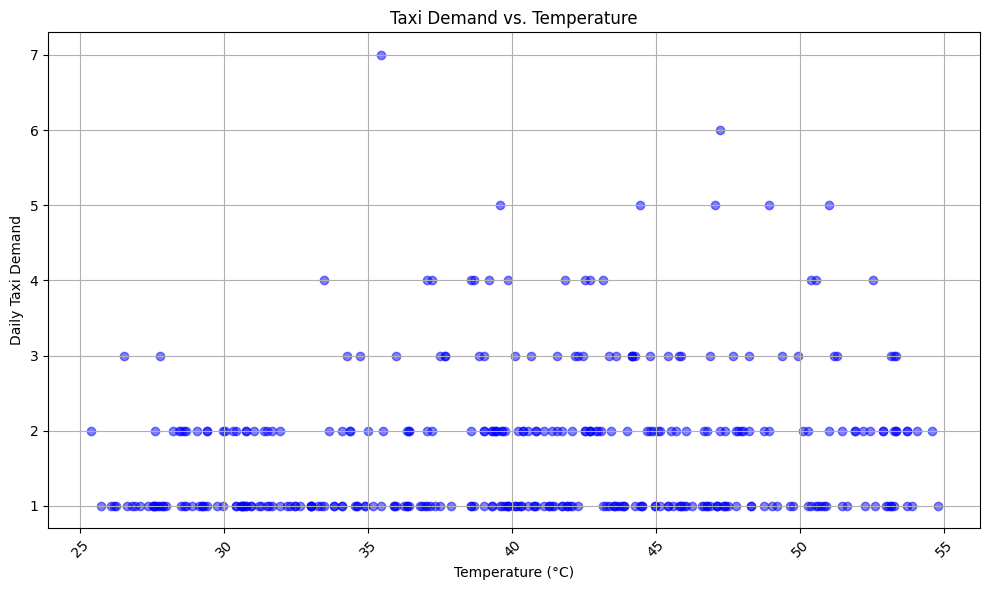

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(merged_data['temperature_2m'], merged_data['taxi_demand'], alpha=0.5, color='b')
plt.title('Taxi Demand vs. Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Daily Taxi Demand')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


*Answer to research question:*                      
In conclusion, while the scatter plot analysis suggests no direct correlation between temperature and taxi demand in NYC, further investigation into various factors influencing transportation preferences could provide a more comprehensive understanding of urban mobility patterns.

This structured approach acknowledges the findings from the scatter plot while framing your observations and insights effectively.

###  `Visual 2 - Trip Duration vs. Precipitation`

Visualization: Scatter plot showing the relationship between trip duration and precipitation.


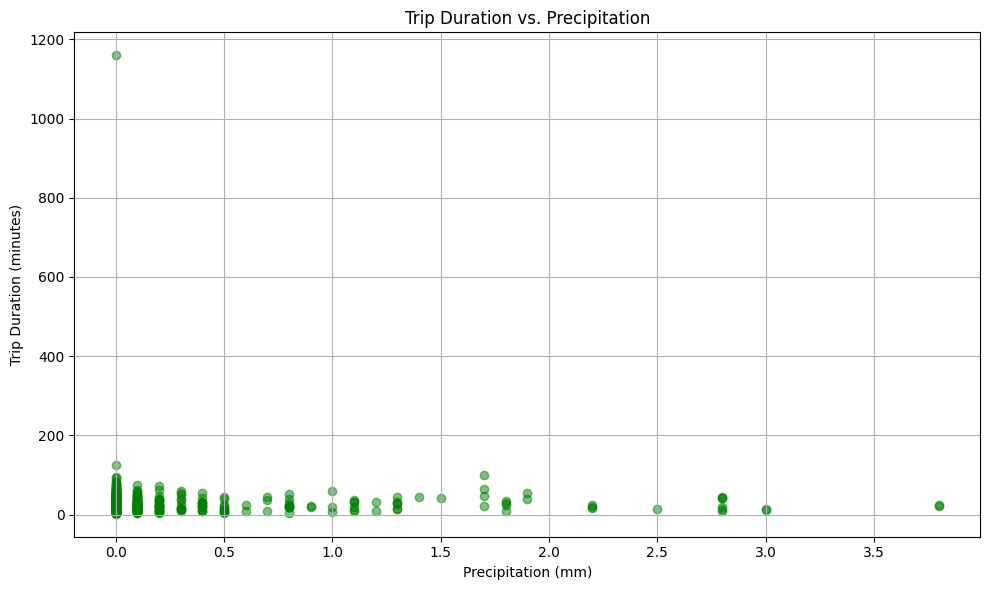

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'taxi' and 'weather' are your DataFrames
# Convert dropoff_date and date columns to datetime with timezone aware in 'taxi'
taxi['dropoff_date'] = pd.to_datetime(taxi['dropoff_date'], utc=True)
taxi['date'] = pd.to_datetime(taxi['date'], utc=True)

# Convert 'date' column in 'weather' to datetime with timezone aware
weather['date'] = pd.to_datetime(weather['date'], utc=True)

# Merge 'taxi' and 'weather' on 'date'
merged_data = pd.merge(taxi, weather, on='date', how='inner')

# Calculate trip duration in minutes
merged_data['trip_duration'] = (merged_data['dropoff_date'] - merged_data['date']).dt.total_seconds() / 60.0

plt.figure(figsize=(10, 6))
plt.scatter(merged_data['rain'], merged_data['trip_duration'], alpha=0.5, color='g')
plt.title('Trip Duration vs. Precipitation')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Trip Duration (minutes)')
plt.grid(True)
plt.tight_layout()

plt.show()


*Answer to research question:* Visualization 2:                       
Trip Duration vs. Precipitation                                              
Insight: The scatter plot illustrates that taxi trip durations in NYC tend to be longer during lighter precipitation or no rain, indicating a potential impact of weather on travel times.                       

Explanation: Lighter precipitation levels likely result in smoother traffic conditions or increased taxi demand, leading to longer trip durations compared to heavy rain periods.                       

Implications: Understanding this relationship helps optimize taxi service operations during varying weather conditions, enhancing service reliability and customer satisfaction.                       



### **5.2:** Reflection

If I had more time to complete the project, I would focus on addressing several aspects:

1. **Data Quality and Cleaning**: I would delve deeper into ensuring data completeness and accuracy, particularly in handling missing values and outliers across both taxi and weather datasets.

2. **Further Analysis**: I would explore additional research questions such as the impact of wind speed, humidity, and seasonal variations on taxi trip patterns. This could provide a more comprehensive understanding of how diverse weather factors influence urban transportation dynamics.

3. **Enhanced Visualizations**: I would refine visualizations to better illustrate trends and correlations, possibly using interactive plots to explore temporal and spatial variations in taxi demand and trip characteristics.

4. **Modeling and Predictive Analytics**: Incorporating predictive modeling to forecast taxi demand under different weather scenarios could enhance operational planning and resource allocation for taxi services in NYC.

These actions would not only deepen the analysis but also provide actionable insights for improving taxi service efficiency and resilience to weather-related challenges.
